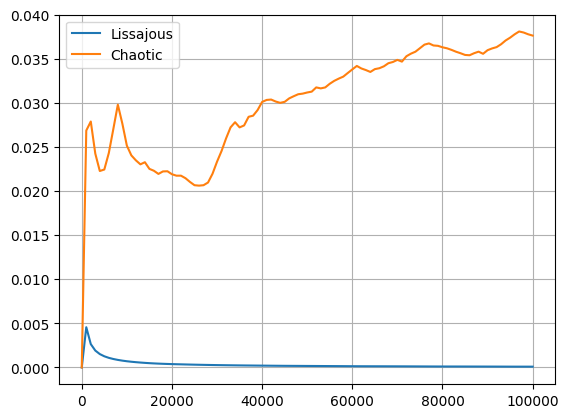

In [ ]:
from numiphy.symlib.expressions import *
from numiphy.odesolvers import *
import matplotlib.pyplot as plt

def g(x0):
    return [x0, 0, 0, (2 - 2*Vfunc(x0, 0) - 0**2)**0.5]

t, x, y = variables('t, x, y')
eps = 0.35
a = -Rational(1, 3)

V = x**2/2 + y**2/2 + eps*(x*y**2 + a*x**3)
ch = HamiltonianSystem(V, x, y)

Vfunc = V.lambdify([x, y])
orb1 = ch.new_varorbit(g(0.5))
orb2 = ch.new_varorbit(g(-0.05))

orb1.get(100000, 0.01, err=1e-10, max_frames=2, split=100)
orb2.get(100000, 0.01, err=1e-10, max_frames=2, split=100)

t1, ind1 = orb1.lyapunov
t2, ind2 = orb2.lyapunov

fig, ax = plt.subplots()
ax.plot(t1, ind1, label='Lissajous')
ax.plot(t2, ind2, label='Chaotic')
ax.grid(True)
ax.legend()

In [ ]:
from numiphy.symlib.expressions import *
from numiphy.odesolvers import *
import matplotlib.pyplot as plt

t, x, y, px, py = variables('t, x, y, px, py')

symode = SymbolicOde(px, py, -x, -y, symbols=[t, x, y, px, py])
ode_fast = symode.to_lowlevel(stack=True)
ode_mid = symode.to_lowlevel(stack=False)
ode_slow = symode.to_python()
res: dict[ODE, OdeResult] = {ode_slow: None, ode_mid: None, ode_fast: None}
for ode in res:
    ics = (0, [1.3, -2.4, 3.7, 0.2])
    res[ode] = ode.solve(ics, 500, 0.1, err=1e-8, method='RK4')
    print(round(res[ode_slow].runtime / res[ode].runtime, 2), " times faster than the equivalent python code")

#normalized runtimes should be: 1, ~40 , ~150

In [ ]:
np.all(res[ode_fast].func == res[ode_slow].func) #should be true. C++ and python implementation of the adaptive RK4 method are identical for numbers of the same precision.

In [ ]:
from numiphy.symlib.expressions import *
from numiphy.odesolvers import *
import time

t, x, y, px, py = variables('t, x, y, px, py')

symode = SymbolicOde(px, py, -x, -y, symbols=[t, x, y, px, py])
ode_fast = symode.to_lowlevel(stack=True)
ode_slow = symode.to_python()


params = 12*[dict(ics = (0, [1.3, -2.4, 3.7, 0.2]), t=500, dt=0.1, err=1e-10, cutoff_step=0., method='RK4', max_frames=1000, args=())]

t1 = time.time()
r_fast = ode_fast.solve_all(params, threads=-1)
t2 = time.time()
r_slow = ode_fast.solve_all(params, threads=1)
t3 = time.time()
r_python = ode_slow.solve_all(params)
t4 = time.time()
print(f'Multithreaded Low level ode was {(t3-t2)/(t2-t1)} times faster than single threaded,')
print(f'while it was {(t4-t3)/(t2-t1)} times faster than the pythonic implementation\n')
print(f'Singlethreaded Low level ode was {(t4-t3)/(t3-t2)} times faster than the pythonic implementation.\n')


Compiling ODE...
Done
Multithreaded Low level ode was 4.3378379578246395 times faster than single threaded,
while it was 868.8714850166482 times faster than the pythonic implementation

Singlethreaded Low level ode was 200.3005860210542 times faster than the pythonic implementation.



In [4]:
ode1 = SymbolicOde(px, py, -x, -y, symbols=[t, x, y, px, py])
ode2 = SymbolicOde(px, py, -x, -y, symbols=[t, x, y, px, py])

orb1 = Orbit(ode1)
orb2 = Orbit(ode2)

orb1.set_ics(0, [1.3, -2.4, 3.7, 0.2])
orb2.set_ics(0, [1.3, -2.4, 3.7, 0.2])

integrate_all([orb1, orb2], 100, 0.1)

Compiling ODE...
Done
Compiling ODE...
Done
pybind11_type


ValueError: All orbits passed in the parallel integrator must originate from a copy of the same orbit or from the same compiled module

In [ ]:
def integrate_all(orbits: list[Orbit], Delta_t, dt, err=1e-8, method='RK4', max_frames=-1, args=(), threads=-1)->list[OdeResult]:

    cls = [orb.ode.__class__ for orb in orbits]
    if not all([cls_i is cls[0] for cls_i in cls]) or not hasattr(cls[0], 'dsolve_all'):
        print(cls[0])
        raise ValueError("All orbits passed in the parallel integrator must originate from a copy of the same orbit or from the same compiled module")
    
    ode_data = []
    for orb in orbits:
        ics = orb.current_ics()
        ode_data.append((orb.ode, dict(ics = ics, t=ics[0]+Delta_t, dt=dt, err=err, method=method, max_frames=max_frames, args=args)))

    cls: LowLevelODE = cls[0]

    res = cls.dsolve_all(ode_data, threads)

    for i in range(len(orbits)):
        orbits[i]._absorb_oderes(res[i])
    
    return res

In [8]:
integrate_all([orb1, orb2], 100, 0.1)

<class 'ode_module3.LowLevelODE'>


ValueError: All orbits passed in the parallel integrator must originate from a copy of the same orbit or from the same compiled module

In [10]:
print(isinstance(orb1, 'LowLevelODE'))

TypeError: isinstance() arg 2 must be a type, a tuple of types, or a union

In [1]:
from numiphy.odesolvers import *
from numiphy.symlib.expressions import *

x, y = variables('x, y')

V = x**2 + y**2

orb1 = HamiltonianOrbit(V, (x, y), lowlevel=True, stack=True)
orb1.set_ics(0, [1., 1.5, 0.2, -0.3])
orb1.integrate(100, 0.1, err=1e-8, cutoff_step=1e-10)
orb2 = orb1.clone()
orb2.integrate(15, 0.1)

Compiling ODE...
Done


In [2]:
orb1

In [3]:
orb1.t

array([0.00000000e+00, 2.79021589e-02, 5.24784081e-02, ...,
       9.99581781e+01, 9.99853728e+01, 1.00000000e+02])

In [4]:
orb2.t

array([0.00000000e+00, 2.79021589e-02, 5.24784081e-02, ...,
       1.14900000e+02, 1.15000000e+02, 1.15000000e+02])

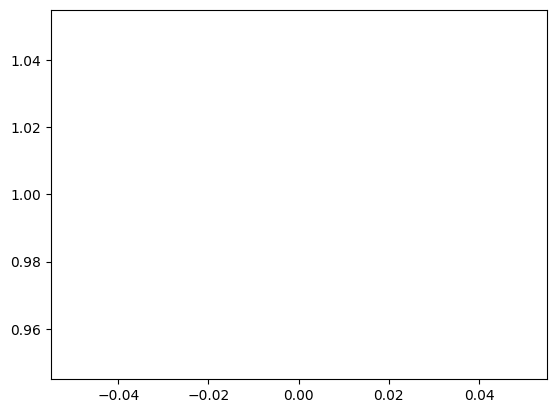

In [9]:
plt.plot(orb1.t, orb1.x[0])

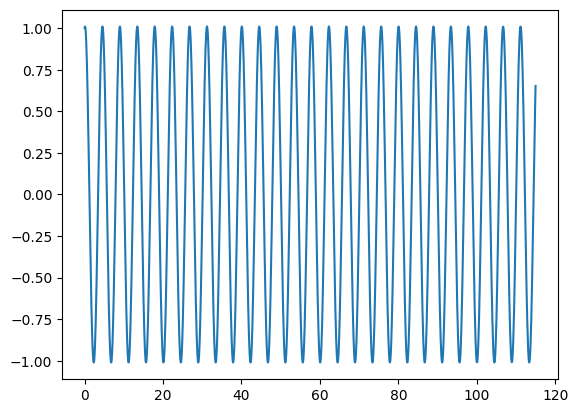

In [8]:
plt.plot(orb2.t, orb2.x[0])

In [7]:
orb1.reset()